# Анализ динамики числа аренд, наличие связи с погодными условиями и выходными

In [1]:
#Импорт необх библиотек
import pandas as pd 
import requests 
from urllib.parse import urlencode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#### Загружаю данные по апи

In [4]:
# используем api 
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key = 'https://disk.yandex.ru/d/h9u6tWco1EFfaA' 
 
# получаем url 
final_url = base_url + urlencode(dict(public_key=public_key)) 
response = requests.get(final_url) 
download_url = response.json()['href']

In [5]:
# загружаем файл в df 
download_response = requests.get(download_url) 
df = pd.read_csv(download_url, sep=',') 
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [7]:
df.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

In [8]:
#Конвертируем в дату
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [11]:
# Функция первичного обзора данных
def review(data):
    display(data.head(5))
    print(data.info())
    print('Пропуски:', data.isna().sum())
    print('Явные дубликаты:')
    if data.duplicated().sum() > 0:
        print(data.duplicated().sum())
    else:
        print('Не найдено')

In [12]:
review(df)

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17414 entries, 0 to 17413
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   timestamp     17414 non-null  datetime64[ns]
 1   cnt           17414 non-null  int64         
 2   t1            17414 non-null  float64       
 3   t2            17414 non-null  float64       
 4   hum           17414 non-null  float64       
 5   wind_speed    17414 non-null  float64       
 6   weather_code  17414 non-null  float64       
 7   is_holiday    17414 non-null  float64       
 8   is_weekend    17414 non-null  float64       
 9   season        17414 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 1.3 MB
None
Пропуски: timestamp       0
cnt             0
t1              0
t2              0
hum             0
wind_speed      0
weather_code    0
is_holiday      0
is_weekend      0
season          0
dtype: int64
Явные дубликат

### Для начала попробую посмотреть на число поездок по датам и времени. Построю график, где:
- по оси x – дата (timestamp)
- по оси y – число поездок (cnt)

In [13]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [17]:
count_cnt = df.groupby('timestamp').agg({'cnt':'sum'})
count_cnt

,cnt
timestamp,
2015-01-04 00:00:00,182
2015-01-04 01:00:00,138
2015-01-04 02:00:00,134
2015-01-04 03:00:00,72
2015-01-04 04:00:00,47
...,...
2017-01-03 19:00:00,1042
2017-01-03 20:00:00,541
2017-01-03 21:00:00,337


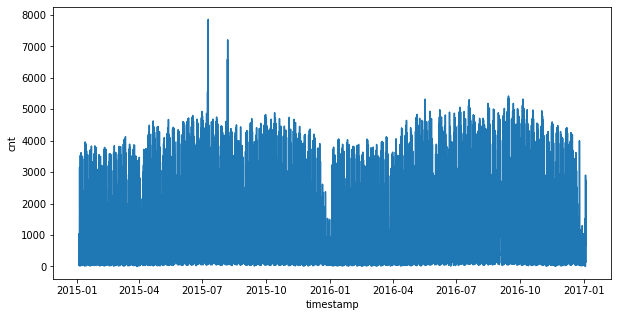

In [23]:
plt.figure(figsize=(10,5))
sns.lineplot(data=count_cnt,x='timestamp',y='cnt')

##### Очень сложно что-то понять, нужно преобразовать данные, чтобы увидеть тренды

___
##### Возможно, дело в том, что данные нужно преобразовать

In [41]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


In [42]:
#убираю дату в индекс
df_r = df.set_index('timestamp')

df_r

,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
timestamp,,,,,,,,,
2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...
2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0


In [43]:
df_for_v = df_r.resample(rule='D').cnt.sum().to_frame()

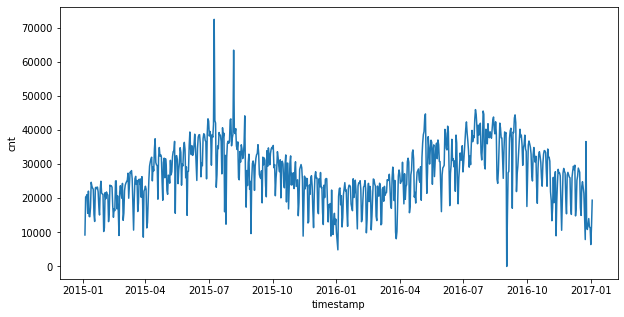

In [44]:
plt.figure(figsize=(10,5))
sns.lineplot(data=df_for_v,x='timestamp',y='cnt')

In [45]:
df_for_v.describe()

,cnt
count,731.000000
mean,27231.151847
std,8660.727499
min,0.000000
25%,21912.000000
50%,27001.000000
75%,33427.500000
max,72504.000000


### Выводы: 
1. Зимой число аренд меньше, чем летом 
2. Встречаются как очень резкие скачки числа аренд, так и падения
3. Максимальное число аренд за день составляет более 70 000 

Я обнаружила  на графике некоторые скачки. Проверю, что же могло произойти в те дни - и насколько эти изменения для неожиданны. Для этого я попробую построить доверительный интервал вокруг данных - всё, что выпадает за его пределы, будет считаться аномалией, и на отдельные из них мы потом и посмотрим.

Однако не всё так просто. Я работаю с временным рядом - последовательностью значений, меняющейся во времени. Я не могу просто так посчитать доверительный интервал для всего: так я могу упустить важные характеристики данных! Например, сезонные колебания. 

Чтобы учесть этот момент, я построю доверительный интервал, используя скользящее среднее. Для этого разделим дальнейшие действия на несколько этапов:

1. сначала посчитаем скользящее среднее, чтобы сгладить ряд
2. далее – разницу между наблюдаемыми и сглаженными значениями
3. определим верхние и нижние границы 99% доверительного интервала 
найдем причины аномалий!

На данном шаге возьмите агрегированные данные по дням с предыдущего шага и посчитайте скользящее среднее с окном 3. В качестве ответа укажите полученное число аренд за 2015-07-09, округлив значение до целого.

##### Используя агрегированные данные по дням и я посчитаю скользящее среднее с окном 3.

In [47]:
#df_for_v
df_for_v.head()

,cnt
timestamp,
2015-01-04,9234
2015-01-05,20372
2015-01-06,20613
2015-01-07,21064
2015-01-08,15601


In [52]:
rolling_df = df_for_v.rolling(3).mean()
rolling_df.head()

,cnt
timestamp,
2015-01-04,NaN
2015-01-05,NaN
2015-01-06,16739.666667
2015-01-07,20683.000000
2015-01-08,19092.666667


In [53]:
#df_for_v.rolling(3).mean().query('timestamp	 =="2015-07-09"')

##### Затем я посчитаю разницу между наблюдаемыми и значениями, подсчитанными с помощью скользящего среднего. И найду стандартное отклонение.

In [56]:
#нахожу разницу между наблюдаемыми и подсчитанными значениями
diff_value = df_for_v - rolling_df

In [64]:
#нахожу стандартное отклонение 
std = float(np.std(diff_value))
std

#4558.586641

4558.58664111794

##### Определю границы 99% доверительного интервала

Для этого нужно взять данные, полученные при расчете скользящего среднего, и создать следующие объекты:

- upper_bound – верхняя граница; к скользящим средним прибавляем 2.576∗std
- lower_bound – нижняя граница; вычитаем 2.576∗std

Полученные значения запишите в новые столбцы датафрейма с агрегированными данными.

Чему равно значение верхней границы для последнего наблюдения?

Note: в качестве std нужно брать стандартное отклонение без округления.

Note 2: понадобиться убрать даты из индекса - иногда из-за этого колонки могут не присваиваться в датафрейм..reset_index().

In [60]:
rolling_df.head()

,cnt
timestamp,
2015-01-04,NaN
2015-01-05,NaN
2015-01-06,16739.666667
2015-01-07,20683.000000
2015-01-08,19092.666667


In [72]:
rolling_df['upper_bound'] = rolling_df['cnt'] + (2.576 * std)

In [73]:
rolling_df['lower_bound'] = rolling_df['cnt'] - (2.576 * std)

In [74]:
rolling_df.head()

,cnt,upper_bound,lower_bound
timestamp,,,
2015-01-04,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN
2015-01-06,16739.666667,28482.585854,4996.747479
2015-01-07,20683.000000,32425.919188,8940.080812
2015-01-08,19092.666667,30835.585854,7349.747479


In [75]:
rolling_df.tail()

,cnt,upper_bound,lower_bound
timestamp,,,
2016-12-30,12682.000000,24424.919188,939.080812
2016-12-31,12347.333333,24090.252521,604.414146
2017-01-01,9803.666667,21546.585854,-1939.252521
2017-01-02,9889.333333,21632.252521,-1853.585854
2017-01-03,12560.000000,24302.919188,817.080812


In [76]:
round(24302.919188,2)

24302.92

##### Посмотрим аномально высокие значения и найдем день, когда число аренд было наибольшим. Найдем причину данной аномалии.

In [77]:
rolling_df.head()

,cnt,upper_bound,lower_bound
timestamp,,,
2015-01-04,NaN,NaN,NaN
2015-01-05,NaN,NaN,NaN
2015-01-06,16739.666667,28482.585854,4996.747479
2015-01-07,20683.000000,32425.919188,8940.080812
2015-01-08,19092.666667,30835.585854,7349.747479


In [84]:
rolling_df['upper_bound']

timestamp
2015-01-04             NaN
2015-01-05             NaN
2015-01-06    28482.585854
2015-01-07    32425.919188
2015-01-08    30835.585854
                  ...     
2016-12-30    24424.919188
2016-12-31    24090.252521
2017-01-01    21546.585854
2017-01-02    21632.252521
2017-01-03    24302.919188
Freq: D, Name: upper_bound, Length: 731, dtype: float64

In [85]:
df_for_v['upper_bound'] = rolling_df['upper_bound']

In [88]:
df_for_v.fillna(0,inplace=True)

In [93]:
df_for_v.query('cnt>upper_bound')

,cnt,upper_bound
timestamp,,
2015-01-04,9234,0.000000
2015-01-05,20372,0.000000
2015-07-09,72504,62447.919188
2015-08-06,63468,58370.252521
2016-09-04,27512,26001.919188
2016-12-25,36653,31393.585854


2015-07-09 значения числа аренд было наибольшим

**В чем может быть причина столь высокого числа аренд в этот день?**

In [95]:
#weather_code
#t1
#is_holiday
#is_weekend	
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [96]:
df.query('timestamp == "2015-07-09"')

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
4453,2015-07-09,400,16.0,16.0,55.0,14.0,1.0,0.0,0.0,1.0


In [ ]:
# в этот день было 16 градусов, было ясно, не праздник и не выходной. скорость ветра 14км/ч это характеризуется как слабый ветер. 

Из новостной сводки - в этот день была 24-часовая стачка работников метро

##### Проделаем аналогичную операцию для дней, когда число аренд оказалось ниже ожидаемого. В чем может быть причина падения числа аренд 2016-09-02?

In [97]:
df_for_v['lower_bound'] = rolling_df['lower_bound']
df_for_v.fillna(0,inplace=True)

In [98]:
df_for_v.query('cnt<lower_bound')

,cnt,upper_bound,lower_bound
timestamp,,,
2015-05-14,15609,40452.252521,16966.414146
2015-07-12,23240,47779.585854,24293.747479
2015-07-24,16034,42756.585854,19270.747479
2015-08-24,17400,41272.252521,17786.414146
2015-11-14,8898,32780.252521,9294.414146
2016-09-02,0,37829.252521,14343.414146
2016-09-10,17080,43004.919188,19519.080812
2016-09-16,21967,47936.252521,24450.414146
2016-11-12,8990,32620.919188,9135.080812


In [99]:
df.query('timestamp == "2016-09-02"')

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season


In [100]:
df['month'] = df['timestamp'].dt.strftime('%Y-%m')

In [102]:
df.query('month == "2016-09-02"')

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,month


In [103]:
#Данных по 2016-09-02 нет, соответственно это может быть ошибка ввода данных

____
# Мои выводы:
1. Я провела предварительный анализ данных: проверила число наблюдений и столбцов, наличие пропусков. Привела переменные к нужным типам. **Дубликаты не обнаружены, аналогично и с пропусками - не обнаружены.**
2. Построила график - динамику числа поездок. Выяснила, что : **зимой число аренд меньше, чем летом, встречаются как очень резкие скачки числа аренд, так и падения, максимальное число аренд за день составляет более 70 000**
3. Проанализировала аномальные значения. **2015-07-09 значения числа аренд было наибольшим, тк в этот день была 24-часовая стачка работников метро**